# Import packages

In [105]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [106]:
data_file_name = 'dataset.xlsx'
data_dir_path = '.'
data_file_path = os.path.join(data_dir_path, data_file_name)
print(data_file_path)
# Load 'data' spreadsheet
df = pd.read_excel(open(data_file_path, 'rb'), sheetname='data', header=1)

print(df.head())
print(df.columns)

./dataset.xlsx
        Date    KOSPI  KOSDAQ  Avgerage_Temperature  Lowest_Temperature  \
0 2016-01-04  1918.76  677.79                  10.4                 7.6   
1 2016-01-05  1930.53  684.07                   5.3                 3.2   
2 2016-01-06  1925.43  687.27                   4.8                 1.8   
3 2016-01-07  1904.33  679.66                   3.9                 1.1   
4 2016-01-08  1917.62  682.56                   2.5                -0.5   

   Highest_temperature  Precipitation  Avgerage_Wind_Speed  \
0                 15.2            0.0                  2.7   
1                  8.1            0.2                  3.1   
2                  9.9            0.0                  2.9   
3                  8.5            0.0                  2.7   
4                  6.9            0.0                  2.9   

   Average_Relative_humidity  Daylight_Hours  Cloud_Cover  Duration_of_Fog  \
0                       46.3             8.6          0.8              0.0   
1    

# Preprocessing - fill in missing values

In [107]:
def fill_in_missing_data(data, window_size):
    num_of_data = len(data)
    indices = np.where(np.isnan(data))[0]

    for i in indices:
        values = []
        distances = []
        for j in range(1,window_size+1):
            if i-j >= 0 and not np.isnan(data[i-j]):
                values.append(data[i-j])
                distances.append(j)
            if i+j < num_of_data and not np.isnan(data[i+j]):
                values.append(data[i+j])
                distances.append(j)

        values = np.array(values)
        distances = np.array(distances)
        inverse_distances = 1.0 / distances
        weights = inverse_distances / np.sum(inverse_distances)
        filling_value = np.sum(np.multiply(values, weights))
        data[i] = filling_value
    return data

def test_fill_in_missing_data(data, window_size):
    modified_data = fill_in_missing_data(np.copy(data), 3)
    plt.plot(modified_data)
    plt.show()
#     data[np.where(np.isnan(data))] = 0
#     plt.plot(data)
#     plt.ylim(1800, 2100)
#     plt.show()
    

In [108]:
kospi = df['KOSPI']
kosdaq = df['KOSDAQ']

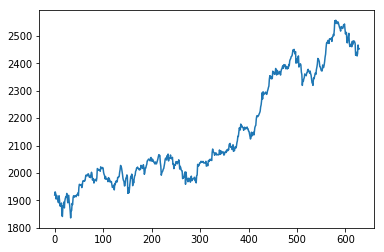

In [109]:
test_fill_in_missing_data(np.copy(kospi),3)

In [110]:
# fill in missing values
df['KOSPI'] = fill_in_missing_data(np.copy(kospi), 3)
df['KOSDAQ'] = fill_in_missing_data(np.copy(kosdaq), 3)

# LSTM

In [111]:
df.head()

,Date,KOSPI,KOSDAQ,Avgerage_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Avgerage_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,0.8,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,7.0,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,5.6,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,0.9,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,0.8,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660
